In [4]:
# Initialize Otter
import otter
grader = otter.Notebook("mcmc.ipynb")

In [2]:
# If modules have not been installed yet:
%pip install -r requirements.txt

# Restart kernel afterwards, if needed

Note: you may need to restart the kernel to use updated packages.


# Markov Chain Monte Carlo and Applications

v1.0 (2018 Spring) Tavor Baharav, Kaylee Burns, Gary Cheng, Sinho Chewi, Hemang Jangle, William Gan, Alvin Kao, Chen Meng, Vrettos Muolos, Kanaad Parvate, Ray Ramamurti, Kannan Ramchandran

v1.1 (2019 Fall) William Gan, Justin Hong, Raghav Anand, Alex Li, Katie Kang, Eric Liu, Aditya Mishra, Kevin Lu, Michael Whitmeyer, Sean Meng, Alan He, Nikita Dhawan, Tae Hyung Kim, Shyam Parekh

v1.2 (2022 Fall) Tweaks by Axel Li

v1.3 (2023 Spring) Tweaks by Reina Wang

v1.4 (2024 Fall) Tweaks by Tianhao Wu

v1.5 (2025 Spring) Lance Mathias

## Introduction

Markov Chain Monte Carlo methods are a powerful collection of techniques that allow us to sample from a distribution _even if we can't calculate the distribution directly._ This is useful for complex models, whose distributions may be intractable to compute. The idea is that, if we are able to sample from our desired distribution, we can answer any questions we may have about that distribution.

## What is MCMC?

Our goal is to simulate a Markov chain with a state for each outcome in our probability space. If the stationary distribution of the chain matches the distribution we want to sample from, then a random walk on the chain should perform like a sequence of samples from our desired distribution.

In this lab we will be focusing on the Metropolis-Hastings algorithm, but this is not the only kind of MCMC method. Gibbs sampling, which you may have encountered in CS 188, is also a MCMC method. Gibbs sampling, however, requires computing a conditional distribution for each random variable in your model, which can be impractical and inefficient for some problems.

We'll also explore an application of our algorithm to a sneaky spy challenge: use Metropolis-Hastings to decode the secret messages Gary is sending to Tavor! 🕵️

## Developing Metropolis Hastings (MH)

Our task is to define a set of transition and acceptance probabilities so that we have an aperiodic Markov Chain whose stationary distribution $\pi(x)$ is equal to our target distribution $P(x)$. The MH algorithm does this implicitly by defining a procedure for transitioning between states. However, it has some assumptions. In particular, it assumes that you can compute:

- $f(x)$, **a directly proportional estimate** of $P(x)$, i.e. $P(x) = \frac{f(x)}{\sum_{y \in \mathcal{X}} f(y)}$.
- $g(x, \cdot)$, a proposal distribution for the next state, where $x$ is your current state.

The MH algorithm says, at each time step:

- Propose the next candidate state $y$ according $g(x,\cdot)$.
- Accept $y$, with probability $A(x,y) = min\{1, \frac{f(y)g(y,x)}{f(x)g(x,y)}\}$.
- If you accept the proposal, transition to $y$. Otherwise, stay in $x$.

Following this procedure, the stationary distribution of the implicitly defined Markov Chain will be $P(x)$. Thus you can take a random walk to sample from $P(x)$. However, in practice, the following two extensions are made:

- Taking every step-th state in the random walk. This helps reduce the dependence between samples.
- Letting the chain walk a bit so that the distribution can converge to the stationary distribution.

In [1]:
# a bit of setup
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats

#######################################
###   PDFs of three distributions   ###
#######################################

def normal(mu,sigma):
    return lambda x: stats.norm.pdf(x,loc = mu, scale = sigma)

def exponential(lam):
    return lambda x: lam*math.exp(-lam*x) if x >=0 else 0

def gauss_mix(p,mu1,sig1,mu2,sig2):
    """
    Gaussian mixture with probabilities of selection being p and 1-p for N(mu1,sig1) and N(mu2,sig2) respectively
    """

    return lambda x: p*stats.norm.pdf(x,loc = mu1, scale = sig1) + (1-p)*stats.norm.pdf(x, loc = mu2, scale = sig2)

#######################################
###   Plotting and Graping Utils    ###
#######################################

def plot_transitions(samples, figname=None):
    plt.plot([i for i in range(len(samples))], samples)
    if figname:
        plt.title(figname)
    plt.show()

def plot_histogram_and_transitions(samples, figname=[]):
    plt.hist(samples)
    if isinstance(figname, list) and len(figname) == 2:
        plt.title(figname[0])
    plt.show()
    plot_transitions(samples, figname[1])


## Metropolis-Hastings Implementation

In the cell below, implement Metropolis-Hastings according to the doc string. It should work for generic proposal, acceptance, and intitialization functions.

In [6]:
def metropolis_hastings(proposal_func, init_func, score_func,
                        num_iters, step=30):
    """
    Runs the metropolis-hastings algorithm for
    num_iters iterations, using proposal_func
    to generate candidate states and scorer to
    assign probability scores to candidate
    states.
    
    proposal_func: function that proposes
        candidate state; takes in current state as
        argument and returns candidate state
    init_func: function that proposes starting
        state; takes no arguments and returns a
        sample state
    score_func: function that calculates f(y)/f(x)
        * g(y,x)/g(x,y); takes in two state samples
        (the current sample x then the candidate y).
    
    Returns a sequence of every step-th sample. You 
    should sample regardless of whether a transition 
    occurs. The length of the final sequence should 
    be num_iters // step.
    """
    ret = []
    x = init_func()
    for i in range(1, num_iters+1):
        y = proposal_func(x)
        A = min(1, score_func(x, y))
        x = y if np.random.rand() < A else x
        if (i%step==0): ret.append(x)
    return ret

In [8]:
grader.check("metropolis_hastings_implementation")

metropolis_hastings_implementation results: All test cases passed!

## Sampling from Distributions Using MH

Now that we have a method for sampling from distributions, let's apply it to some models. We'll start with very simple models so that we can compare the results from sampling with what we can compute analytically. This is also a useful opportunity for you to debug your implementation. Your implementation should be able to model a Gaussian and exponential distribution successfully.

*Note: Our proposal distribution will be a normal distribution centered around our current state for the purposes of this lab. Take this into account when analyzing these examples.*

*An interesting fact to note is that the algorithm works even for these **continuous distributions**. In this case the underlying Markov Chain will have a continuous state space ($\mathbb{R}$)*

## A Friendly Gaussian: $\mathcal{N}(60, 1)$

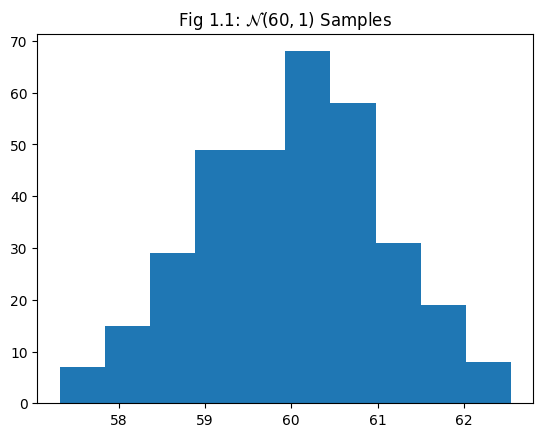

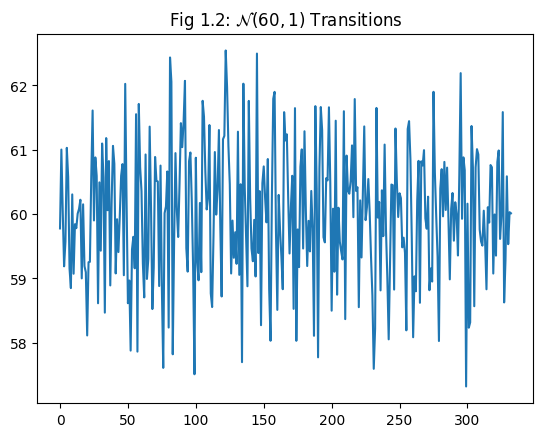

In [9]:
sample_prior = lambda: np.random.normal(loc=60)
sample_candidate = lambda theta: np.random.normal(loc=theta)
scorer = lambda x, y: (math.exp(-((y - 60)**2)/2)) / (math.exp(-((x - 60)**2)/2))
normal_samples = metropolis_hastings(sample_candidate, sample_prior, scorer, 10000)
plot_histogram_and_transitions(normal_samples, ['Fig 1.1: $\mathcal{N}(60, 1)$ Samples', 'Fig 1.2: $\mathcal{N}(60, 1)$ Transitions'])

## Exponential Distribution: $\text{Exponential}(0.5)$

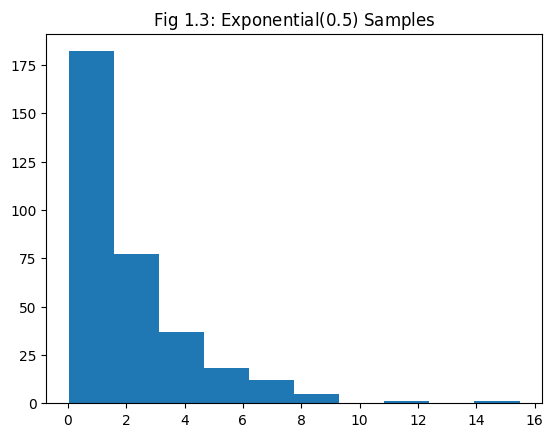

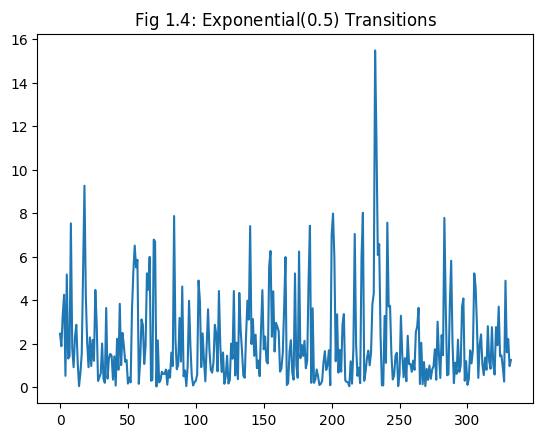

In [14]:
exp_pdf = exponential(0.5)
exp_scorer = lambda x,y: exp_pdf(y) / exp_pdf(x)
exp_prior = lambda : 10
exp_samples = metropolis_hastings(sample_candidate, exp_prior, exp_scorer, 10000)
plot_histogram_and_transitions(exp_samples, ['Fig 1.3: $\\text{Exponential}(0.5)$ Samples', 'Fig 1.4: $\\text{Exponential}(0.5)$ Transitions'])

## Effects of Initial Distribution, Convergence Diagnosis and Burn-in Time
In the case of the Gaussian above, our `init_function`(initial distribution) was $\mathcal{N}(60,1)$ which is exactly the same as the distribution we were trying to sample, i.e, we started the chain from the stationary distribution. However in general, we obviously don't have the ability to sample from the distribution we were trying to sample from in the first place! Notice that in the exponential, it goes down drastically from 10 where we started the chain, and oscillates more around lower values.

Now run the following code, and answer the questions below.

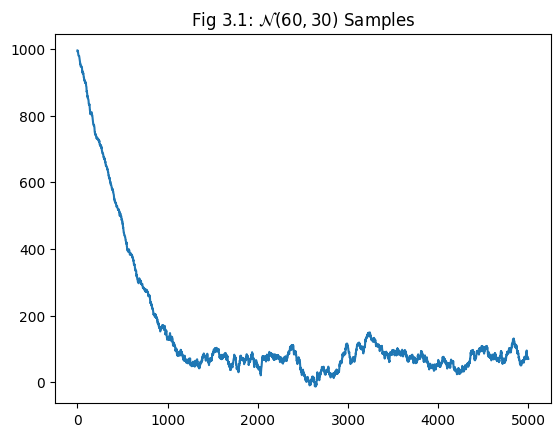

In [15]:
sample_prior = lambda: np.random.normal(loc=1000)
sample_candidate = lambda theta: np.random.normal(loc=theta, scale=3)
normal_pdf = normal(60,30)
scorer = lambda x, y: normal_pdf(y) / normal_pdf(x)
normal_samples = metropolis_hastings(sample_candidate, sample_prior, scorer, 5000, 1)
plot_transitions(normal_samples, 'Fig 3.1: $\mathcal{N}(60, 30)$ Samples')

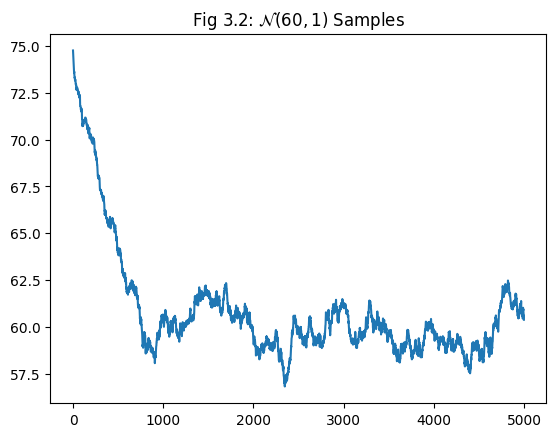

In [16]:
sample_prior = lambda: np.random.normal(loc=75)
sample_candidate = lambda theta: np.random.normal(loc=theta, scale=0.1)
normal_pdf = normal(60,1)
scorer = lambda x, y: normal_pdf(y) / normal_pdf(x)
normal_samples = metropolis_hastings(sample_candidate, sample_prior, scorer, 5000, 1)
plot_transitions(normal_samples, 'Fig 3.2: $\mathcal{N}(60, 1)$ Samples')

<!-- BEGIN QUESTION -->

**Question 1:** In the last trials we ran, are there some samples we need to ignore at the beginning? Explain what is happening with the Markov Chain based on the parameters we've used and your observations from the state vs. iteration plot.

Examining Figures 2.1 and 2.2, tell us approximately how many samples we need to ignore (or 0 if we don't need to ignore any samples). 

Feel free to use this space to draft your answer. When you finish, remember to paste your response and any relevant plots/figures **into the accompanying Gradescope assignment**.

<!-- END QUESTION -->

## Drawbacks of MCMC Techniques

Now we'll evaluate the effectiveness of our sampling technique on a variety of models. The examples below will highlight some of the drawbacks and idiosyncrasies of MCMC techniques. We will look at this in the context of distributions with two peaks (two separated regions of high probability), also known as bimodal distributions. We will see that the peaks may not be sampled appropriately.

## Bimodal Mixture of Gaussians

A mixture of Gaussians is obtained when you have two subpopulations ('classes') each distributed normally($\mathcal{N}(\mu_1,\sigma_1^2)$ and $\mathcal{N}(\mu_2,\sigma_2^2)$) . An example is heights of people with the subclasses of men and women. In the mixture model the 'classes' have probabilities $p$ and $1-p$ respectively. So the pdf of this distribution would be 
$$
p \cdot f_X(x\ |\text{ class 1}) + (1-p)\cdot f_X(x\ |\text{ class 2}) = p\cdot \frac{1}{\sqrt{2\pi \sigma_1^2}} \cdot \exp \left( {-\frac{(x - \mu_1)^2}{2\sigma_1^2}} \right) + \left(1-p\right) \cdot \frac{1}{\sqrt{2\pi \sigma_2^2}} \cdot \exp \left({-\frac{(x - \mu_2)^2}{2\sigma_2^2}} \right)
$$

For there to be two peaks in the pdf (to be bimodal), there should be (loosely speaking) sufficient separation between the means with respect to the standard deviations(the widths of the distributions). Otherwise if the peaks are too close relative to the widths, it is possible for the mixture to lead to just one central peak between the two means. There are exact conditions for this you can look up if you are interested. 

For this part we will be using a mixture with equal probabilities $(0.5)$ on each of the individual Gaussians with means $60$ and $40$. Try MH on this distribution for standard deviations of $5,3,1$ for each of the individual Gaussians. You should see that one of the peaks dominates (could be either one) as the standard deviation reduces even though both classes have an equal probability. For low std devs 2 and 1, only one peak should show up. 

In [21]:
def sample_from_bimodal(stdev):
    """Samples from bimodal mixture of Gaussians
    with standard deviation stdev, as described above."""
    
    pdf = gauss_mix(0.5,40,stdev,60,stdev)

    sample_candidate = lambda theta: np.random.normal(loc=theta)
    new_scorer = lambda x,y: pdf(y)/pdf(x) 
    new_prior = lambda : 50

    points = metropolis_hastings(sample_candidate, new_prior, new_scorer, 10000)
    fignames = [f"STD={stdev}"]*2
    plot_histogram_and_transitions(points, fignames)

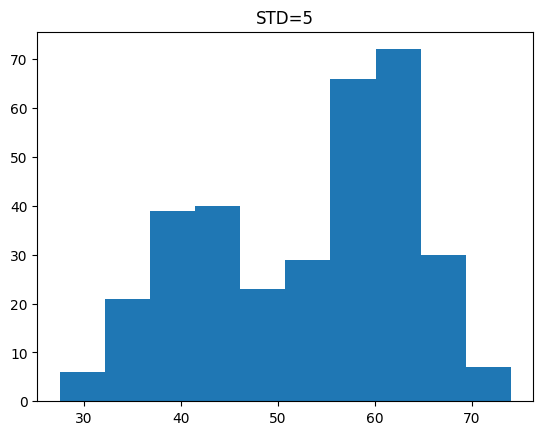

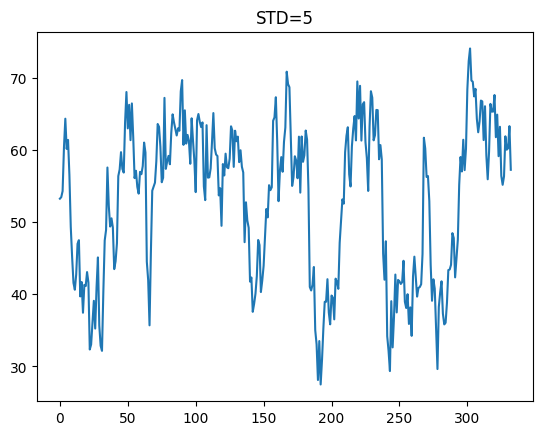

In [22]:
sample_from_bimodal(5)

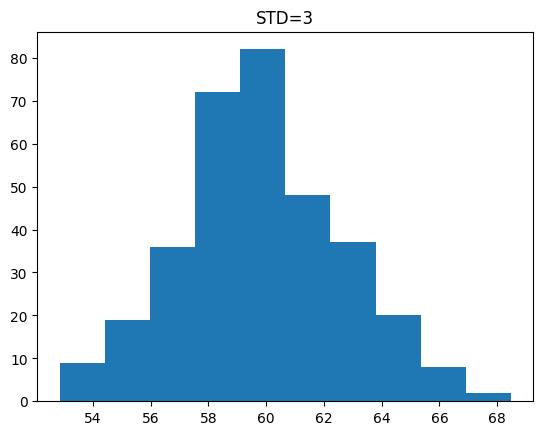

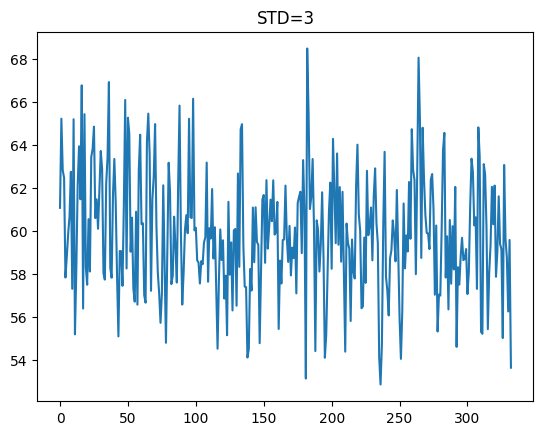

In [23]:
sample_from_bimodal(3)

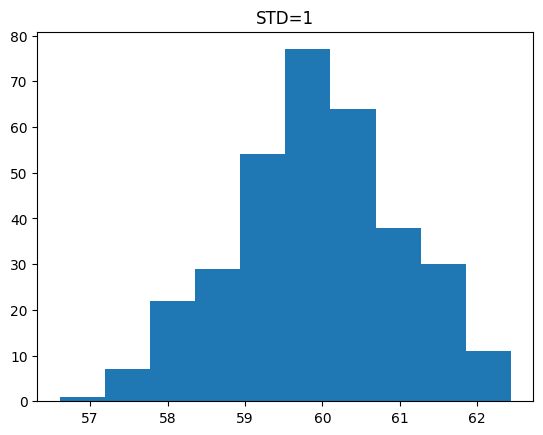

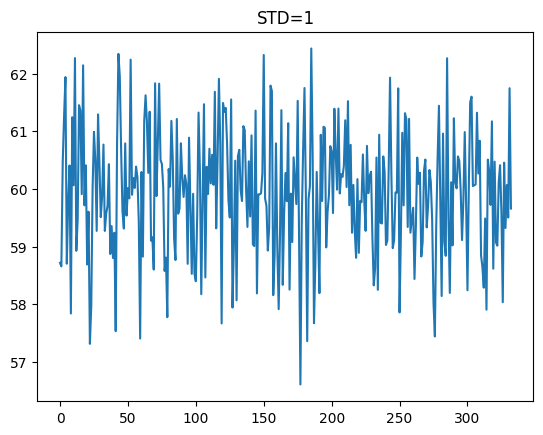

In [24]:
sample_from_bimodal(1)

What effect do you think changing the standard deviation has? What possible disadvantage of MH does this bimodal distribution show?

<!-- BEGIN QUESTION -->

What effect do you think changing the standard deviation has? What possible disadvantage of MH does this bimodal distribution show?

Answer the following questions on the corresponding Gradescope assignment:

**Question 2:** What happens to the jumps in the transition plots as the standard deviation decreases?
    
- The jumps become more frequent
- The jumps become less frequent
- The jumps stay the same
- There are no jumps in the transition plots

**Question 3:** As the standard deviation decreases, what happens to the likelihood of proposing a state on the other peak with high probability?
    
- It increases
- It decreases
- It remains the same
- It becomes zero

**Question 4:** What is a disadvantage of MH for bimodal distributions?
    
- It always samples from only one peak
- It requires too many iterations to converge
- It's difficult to determine the number of iterations needed to sample both peaks evenly
- It cannot handle bimodal distributions at all

**Question 5:** How does decreasing the standard deviation affect the separation between high probability regions?
    
- It increases the separation
- It decreases the separation
- It has no effect on the separation
- It eliminates one of the high probability regions

Feel free to use this space to draft your answer. When you finish, remember to paste your response and any relevant plots/figures **into the accompanying Gradescope assignment**.

<!-- END QUESTION -->

## Decoding Secret Messages Using MCMC (4 points)

Now we'll use our algorithm to solve a mystery on the EE 126 staff. Grumpy Gary and Tricky Tavor are sending each other secret messages using a cipher: each character in the message is either an uppercase letter or a space (denoted `_` ) (so there are 27 possible characters). Their cipher permutes the alphabet -- every character maps to another character (or possibly itself), and no two characters map to the same thing. To send a message, they replace each character with the corresponding character in their cipher.

For example, if their cipher was the following:

| A | B | C | D | E | F | G | H | I | J | K | L | M | N | O | P | Q | R | S | T | U | V | W | X | Y | Z | _ |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| X | T | A | G | M | L | C | Q | P | Z | H | W | J | I | E | B | K | O | _ | F | D | U | L | N | R | S | Y |


Then `HELLO WORLD` would translate to `QMWWEYLEOWG`. Your job is to decode their message using the Metropolis-Hastings algorithm you wrote above. Our goal is to find the cipher that maximizes the likelihood of seeing the characters in the translated message. The cipher will be a list of integers representing the letter of the alphabet that the letter corresponding to that index should be translated to. For example, if "g" should be replaced with "a", then `cipher[6]` should equal `0`. **Note: 0-index when counting letters of the alphabet.**

Our model of language will consider each character to be dependent only on the previous character. For example,

$$\mathbb{P}(x_1 = c, x_2 = a, x_3 = t) = \mathbb{P}(x_1 = c)\mathbb{P}(x_2 = a|x_1 = c)\mathbb{P}(x_3 = t|x_2 = a)$$

These transition probabilities will be calculated empirically by counting the number of transitions between every pair of characters in a large corpus of text.

The state space is the set of all ciphers 
$$X = \{\sigma : \sigma \text{ is a permutation of the English alphabet and  ``\_''}\}.$$ 
$|X| = 27!$, so finding the most likely cipher is far too costly to calculate naively, but we can sample from the space of all ciphers intelligently by using Metropolis-Hastings with the following functions:

**Proposals**: To propose new ciphers, we will randomly swap two characters in our cipher.

**Acceptance Function**: Note that because our proposal distribution is symmetric, the acceptance probability becomes $A(x,y) = \min\{1, \frac{f(y)}{f(x)}\}$. 
$f(x)$ is the probability of observing the sequence of characters in the message decoded by cipher $x$: 

$$f(\cdot) = \mathbb{P}(x_1 = \text{letter}_1)\mathbb{P}(x_2 = \text{letter}_2|x_1 = \text{letter}_1)\mathbb{P}(x_3 = \text{letter}_3|x_2 = \text{letter}_2)$$

$f(\cdot)$ is _not_ a valid probability over all ciphers because we don't normalize, but it is sufficient for us to compare two ciphers.

Here is an example of one iteration of the algorithm. If we are dealing with a reduced alphabet of $\{A,B,C,D,\text{' '}\}$ and our current cipher is $[ 2,0,4,3,1 ]$, then we are mapping $A->C, B->A, C->\text{' '}$, etc. If our proposal function suggests the perturbed cipher $[ 4,0,2,3,1 ]$, we will accept this cipher as our new state with probability $\min \{1, \frac{f([ 4,0,2,3,1 ])}{f([ 2,0,4,3,1 ])}\}$.

We wrote functions to find the bigram frequency matrix, which gives the transition probabilities between characters, and to convert messages into a numerical format. To run the starter code below, you will need to run following cell to download corpus from which we will learn the transition probabilities. This will save a file called `war_and_peace.txt` in the current directory.

Some final notes and tips:
- For simplicity's sake, don't worry about the initial $P(x_1 = \text{letter}_1)$: the sequence is 538 characters long, so this initial probability won't affect the relative probability between 2 ciphers by any noticeable amount.
- To translate from letters to numbers quickly, take a look at the built-in `ord` function. Keep in mind that we are only working with uppercase letters, so it will map each letter to an integer in the range 65 to 90.
- For numerical stability, to find $\frac{f(y)}{f(x)}$, compute $\log(f(y)) - \log(f(x))$, and then pass it to the exp function.

In [25]:
# For Linux/MacOS
! curl 'https://www.gutenberg.org/files/2600/2600-0.txt' > war_and_peace.txt
the_secret_message="VTBALNDMNYBQQBSDWVQQUNO RT INVTBLDMNO VYG MNDMNOBNCDAWMGNOG NTWABRWOUNVAINGVO NOGBM NJGBNVR NIWEE R AONVAINDAWSD NVMNWTCBMOBRMNWAMO VINWNQWH NOG NXR VOGNBENER MGNVWRNOGWMNCRBXQ TNCRBZWI MNVMNVNA JNC RMC YOWZ NBANI IDYOWBANOGVONWMNABONR INWMNMDMNR INZ AO IN OYNOGVONGVMNX  ANIBTWAVOWALNOG NPBH MNBENTUNC  RMNVAINOG NZW JNBENTUNE  INU ONXUNORUWALNOBNEBRY NOGWMNCRBXQ TNOBNYBAEBRTNOBNVTBLDMNUBDNUBDRM QENVR NORUWALNOBNYRDMGNBRWLWAVQWOUNVAINDAWSD A MMNVTBALNDMNWMNVNLVT NDQOWTVO QUNYBAZWAYWALNDMNOBNYBAEBRTNOBNT AWVQNQVXBRNVMNOVMHMNVAINVYY CONOG NI VQNBENX WALNPDMONQWH NOG NR MONBENOG NYR JTVO M"
# On Windows download from https://www.gutenberg.org/files/2600/2600-0.txt
# and save as war_and_peace.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3280k  100 3280k    0     0  1320k      0  0:00:02  0:00:02 --:--:-- 1320k


In [26]:
input_file = "war_and_peace.txt"

def build_bigram_freq_matrix(input_file):
    """
    Builds a matrix that represents the transitional
    probabilities between letters in input_file.
    
    bigram_freq_matrix[0][1] is the probability of
    transitioning from the 0th letter of the alphabet
    to the 1st letter of the alphabet, where letters
    are zero-indexed. ' ' (space) is denoted as the
    26th letter of the alphabet.
    """
    counts = np.ones([27, 27])
    with open(input_file, 'r', encoding='utf8') as f:
        for _ in range(100000):
            line = f.readline()
            if len(line) > 2:
                for i in range(len(line) - 2):
                    first_char = ord(line[i].upper()) - 65 if line[i].isalpha() else 26
                    second_char = ord(line[i+1].upper()) - 65 if line[i+1].isalpha() else 26
                    if not (first_char == 26 and second_char == 26) and first_char <= 26 and second_char <= 26:
                        counts[first_char][second_char] += 1
        bigram_freq_matrix = (counts.T / np.sum(counts, axis=1)).T
    return bigram_freq_matrix

def decode(string, ordering):
    """
    Decodes a string according to the given
    ordering.
    
    ordering: a list representing the cipher.
        For example, if in our cipher, 'a'
        should be replaced with 'c', then 
        ordering[0] should equal 2.
    """
    output_str = ""
    for i in string:
        first_char = ord(i.upper()) - 65 if i.isalpha() else 26
        output_str += chr(ordering[first_char] + 65) if ordering[first_char] != 26 else " "
    return output_str

bigram_freq_matrix = build_bigram_freq_matrix(input_file)

### Visualizing the Bigram Frequency Matrix

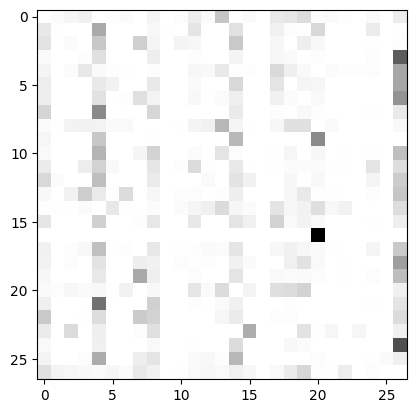

In [27]:
plt.imshow(bigram_freq_matrix, cmap='binary', interpolation='none')    

In [46]:
from itertools import permutations

def charToNum(char):
    if char == " ": return 26
    else: return ord(char)-ord("A")

def starting_state():
    """
    Return a random permutation of indices representing the alphabet.
    """
    alphabet = [i for i in range(27)]
    np.random.shuffle(alphabet)
    return alphabet

assert len(starting_state()) == 27

def sample_candidate(sample):
    """
    To search for new ciphers, create a 
    new cipher from the old cipher with
    two letters swapped.
    
    sample: previous cipher, list
    """
    swap1, swap2 = np.random.choice(np.arange(27), 2, replace=False)
    ret = sample[:]
    ret[swap1], ret[swap2] = ret[swap2], ret[swap1]
    return ret

def make_log_f(decode_string, transition_matrix):
    """
    Generates a function which computes the 
    log of the function f in the description 
    (the probability of observing the sequence 
    of characters in the message decoded by 
    cipher x), which is then used to calculate 
    acceptance probabilities.
    
    decode_string: secret message string
    transition_matrix: matrix representing
        transition probabilities from
        char i to char j.
    """
    def log_f(current_sample):
        ret = 0
        decoded = decode(decode_string, current_sample)
        for i in range(len(decoded)-1):
            c1 = charToNum(decoded[i])
            c2 = charToNum(decoded[i+1])
            ret += math.log(transition_matrix[c1, c2])
        return ret
    return log_f

def make_acceptance_scorer(log_f):
    """
    Calculate the acceptance probability, which is the
    probability of observing the message translated by
    the proposed cipher divided by the probability of
    observing the message translated by the current
    cipher. See notes above about using log likelihood
    for stability.
    
    log_f: function that computes the log of the probability
        of observing the message translated by the current cipher
    """
    def scorer(current_sample, candidate):
        return math.exp(log_f(candidate) - log_f(current_sample))
    return scorer

In [47]:
grader.check("implement_mcmc_decoding")

implement_mcmc_decoding results: All test cases passed!

In [48]:
log_f = make_log_f(the_secret_message, bigram_freq_matrix)
scorer = make_acceptance_scorer(log_f)
samples = metropolis_hastings(sample_candidate, starting_state, scorer, 8000, step=100)

### Watch your Decoding Improve

We print out the first few samples below. As you continue to sample from the space of all ciphers, the quality of your decoding should improve roughly. **You may have to run the algorithm a few times to achieve good results.**


In [49]:
for sample in samples[::len(samples) // 5]:
    print(decode(the_secret_message, sample), '\n')

NWETM BL AEPPEJBINPPK SRFWRU NWEMBL SRNAORL BL SE DBTILO SOR WITEFISK NTU ONSR SOELR XOE NFR UIGGRFRTS NTU BTIJBR NL IWDELSEFL ITLSRNU I PIZR SOR YFRNSO EG GFRLO NIF SOIL DFEYPRW DFEHIURL NL N TRX DRFLDRASIHR ET URUBASIET SONS IL TES FRU IL LBL FRU HRTSRU RSA SONS ONL YRRT UEWITNSITM SOR VEZRL EG WK DRRFL NTU SOR HIRX EG WK GRRU KRS YK SFKITM SE GEFAR SOIL DFEYPRW SE AETGEFW SE NWEMBL KEB KEBFLRPG NFR SFKITM SE AFBLO EFIMITNPISK NTU BTIJBRTRLL NWETM BL IL N MNWR BPSIWNSRPK AETHITAITM BL SE AETGEFW SE WRTINP PNYEF NL SNLZL NTU NAARDS SOR URNP EG YRITM VBLS PIZR SOR FRLS EG SOR AFRXWNSRL 

AMENG US CELLEQUIALLY TORMOF AMEGUS TOACHOS US TE PUNISH THO MINERITY ANF HATO THESO KHE ARO FIDDORONT ANF UNIQUO AS IMPESTERS INSTOAF I LIBO THO WROATH ED DROSH AIR THIS PREWLOM PREVIFOS AS A NOK PORSPOCTIVO EN FOFUCTIEN THAT IS NET ROF IS SUS ROF VONTOF OTC THAT HAS WOON FEMINATING THO JEBOS ED MY POORS ANF THO VIOK ED MY DOOF YOT WY TRYING TE DERCO THIS PREWLOM TE CENDERM TE AMEGUS YEU YEURSOLD ARO 

## Let's Get Sleuthy (3 points)

What did Gary's secret message to Tavor say?

In [50]:
log_probs = [log_f(s) for s in samples]
print(len(log_probs))
best_cipher_index = np.argmax(log_probs)
print(decode(the_secret_message, samples[best_cipher_index]).upper())

80
AMONG US COLLOQUIALLY TERMED AMOGUS TEACHES US TO PUNISH THE MINORITY AND HATE THOSE WHO ARE DIFFERENT AND UNIQUE AS IMPOSTORS INSTEAD I LIKE THE BREATH OF FRESH AIR THIS PROBLEM PROVIDES AS A NEW PERSPECTIVE ON DEDUCTION THAT IS NOT RED IS SUS RED VENTED ETC THAT HAS BEEN DOMINATING THE JOKES OF MY PEERS AND THE VIEW OF MY FEED YET BY TRYING TO FORCE THIS PROBLEM TO CONFORM TO AMOGUS YOU YOURSELF ARE TRYING TO CRUSH ORIGINALITY AND UNIQUENESS AMONG US IS A GAME ULTIMATELY CONVINCING US TO CONFORM TO MENIAL LABOR AS TASKS AND ACCEPT THE DEAL OF BEING JUST LIKE THE REST OF THE CREWMATES


Do you recognize this secret message?

You may notice that sometimes when you run the algorithm, certain letters are not decoded correctly. For example, "crewmates" may be translated as "crexmates." In addition, the decoding may fail catastrophically, never yielding a intelligible message. Try to think about why this might be the case, and then answer the following questions.

**Question 6:** Why might certain letters not be decoded correctly in the MCMC algorithm?
- The MCMC algorithm only works for sampling random data, so it's not suited for decoding a fixed string with a deterministic mapping. 
- Some letters appear infrequently, making it difficult to distinguish between correct and incorrect mappings.
- The English language doesn't have a consistent structure for letter frequencies.
- The algorithm intentionally introduces errors to make the decoding more challenging.

**Question 7:** Why might the decoding fail catastrophically and never yield an intelligible message? Choose the best answer:

- Catastrophic failure is a sign that the original message was not in English.
- If the initial cipher is poor, the algorithm might get stuck in a local optimum.
- The MCMC algorithm has a fixed memory window, so it will fail for long messages.
- Catastrophic failure only occurs when the number of iterations is too small.

**Question 8:** What is the decoded message? Enter the letter corresponding to the correct message.
    return the message that you decoded as a string, all uppercase, without any additional leading or trailing spaces, and with *no quotation marks*. 
    
    For example, you might write `THIS IS A TEST MESSAGE`. 

## Submission Instructions
For this lab, there is **no** export cell. Instead, directly upload your completed `.ipynb` to the relevant Gradescope assignment. Make sure to save your work before uploading!!!

Additionally, make sure all written questions have been answered in the corresponding Gradescope assignment.

## Sources and Further Reading

[1] https://people.eecs.berkeley.edu/~sinclair/cs294/n1.pdf

[2] http://www.mit.edu/~ilkery/papers/MetropolisHastingsSampling.pdf

[3] http://statweb.stanford.edu/~cgates/PERSI/papers/MCMCRev.pdf